# Image Embeddings

A pre-trained CNN (ResNet50, with image weights from ImageNet) is used with the final layer removed to get image embeddings/feature vectors for subsequent ML to judge the impact of book covers on popularity. 

In [1]:
import numpy as np
import pandas as pd
import shutil
import os 
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import tensorflow as tf
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing import image
from keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense

2024-04-09 14:46:50.834251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
print(f"numpy-{np.__version__}")
print(f"pandas-{pd.__version__}")
print(f"keras-{keras.__version__}")
print(f"tensorflow-{tf.__version__}")

numpy-1.24.3
pandas-1.5.3
keras-3.1.1
tensorflow-2.16.1


The ResNet50 model without the top layers (specified by include_top=False) acts as a feature extractor. It takes preprocessed images as input and produces feature maps as output, where each feature map represents higher-level features learned by the model. These feature maps capture various aspects of the input images, such as edges, textures, and object parts.

The requests library was used to get images from URLs, the images were saved locally. See the 'crawl_all_images' notebook to obtain the images.

In [2]:
model = ResNet50(weights='imagenet', include_top=False)

In [3]:
# testing on one image
img_path = 'test_images/2.jpg'
img = image.load_img(img_path, target_size=(224, 224)) # ResNet50 is trained on images of 224 x 224
image_array = image.img_to_array(img) # image to np array
image_expand = np.expand_dims(image_array, axis=0) # to add batch size [img1, img2, img3, ... img100]
preprocessed_image = preprocess_input(image_expand) # ResNet50 pre-processing: normalisation, BGR format
embedding = model.predict(preprocessed_image) # features map / embedding

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [76]:
# testing whether batch processing takes the same time as processing one image
img_path = 'test_images/2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
image_array = image.img_to_array(img) # image to np array
images_array = np.expand_dims(image_array, axis=0) # to add batch size [img1, img2, img3, ... img100]
images = np.array([image_array, image_array, image_array, image_array, image_array])
preprocessed_images_array = preprocess_input(images) # ResNet50 pre-processing: normalisation, BGR format
embedding = model.predict(preprocessed_images_array) # features map / embedding

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


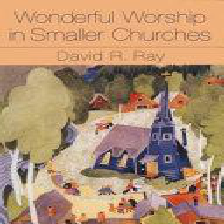

In [75]:
img

In [114]:
# function to remove.jpg from filename to save index only in df
def strip_and_convert(filename):
    return int(filename.split('.')[0])

In [53]:
# load images
directory = 'images'
image_name_list = os.listdir(directory)
image_name_list.sort(key=strip_and_convert)

In [56]:
# generate partitions (perform embeddings in batches to improve computation time)
n = 1024
l = len(image_name_list)
partitions = np.array_split(image_name_list, range(n, l, n))

In [60]:
# process partitions 
partition_number = 0
for partition in partitions:
    print(f"processing partition {partition_number} ({len(partition)} images)...")
    
    embedding_list = []
    images = []
    for image_name in partition:
        img_path = os.path.join(directory, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        image_array = image.img_to_array(img)
        images.append(image_array)
    
    images_array = np.array(images)
    preprocessed_images_array = preprocess_input(images_array) # ResNet50 pre-processing: normalisation, BGR format
    embeddings = model.predict(preprocessed_images_array) # features map / embedding
    
    for embedding in embeddings:
        embedding_flat = embedding.flatten()
        embedding_list.append(embedding_flat)

    df = pd.DataFrame({
        'ImageName': partition,
        'Embedding': embedding_list})
    df['ImageName'] = df['ImageName'].apply(strip_and_convert)
    
    # save in pickle format to recover data in exactly the same format
    print(f"saving results for partition {partition_number}...")
    filename = f"./embeddings_{partition_number}.pickle.gz"
    df.to_pickle(filename)
    print(f"finished processing partition {partition_number}")
    partition_number += 1
    

processing partition 0 (32 images)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
saving results for partition 0...
finished processing partition 0
processing partition 1 (32 images)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
saving results for partition 1...
finished processing partition 1


### Average pooling and linear layer added to reduce vector size to 256

In [104]:
# Load the pre-trained ResNet50 model
# testing one image adding avpool and linear layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a GlobalAveragePooling2D layer
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()

# Define a sequential model
model = tf.keras.Sequential([
    base_model,
    global_avg_pool,
    tf.keras.layers.Dense(256, activation='linear')  # Linear layer to reduce dimensionality
])

# Load and preprocess the image
img_path = 'test_images/2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
image_array = image.img_to_array(img)
image_expand = np.expand_dims(image_array, axis=0)
preprocessed_image = preprocess_input(image_expand)

# Obtain the embedding
embedding = model.predict(preprocessed_image)

print(embedding.shape)  # Output shape after linear layer: (1, 256)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(1, 256)


In [ ]:
# implement above code for partions

In [202]:
# copying slice from images, indices taken from cleaned df
# Define the source and destination directories
source_dir = 'images'
destination_dir = 'slice_images'

# Iterate over the filenames and copy them to the destination folder
for filename in indices_cleaned_df_str:
    source_path = os.path.join(source_dir, filename)
    destination_path = os.path.join(destination_dir, filename)
    shutil.copyfile(source_path, destination_path)


In [205]:
# load images
# want to creat a slice based on cleaned dataset
#directory = 'slice_images'
directory = 'slice_images'
slice_image_name_list = os.listdir(directory)
slice_image_name_list.sort(key=strip_and_convert)

In [192]:
# generate partitions
n = 1024
l = len(slice_image_name_list)
partitions = np.array_split(slice_image_name_list, range(n, l, n))

In [193]:
base_model = ResNet50(weights='imagenet', include_top=False)
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
model = tf.keras.Sequential([
    base_model,
    global_avg_pool,
    tf.keras.layers.Dense(256, activation='linear') 
])

In [163]:
# process partitions 
partition_number = 0
for partition in partitions:
    print(f"processing partition {partition_number} ({len(partition)} images)...")
    
    embedding_list = []
    images = []
    for image_name in partition:
        img_path = os.path.join(directory, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        image_array = image.img_to_array(img)
        images.append(image_array)
    
    images_array = np.array(images)
    preprocessed_images_array = preprocess_input(images_array) # ResNet50 pre-processing: normalisation, BGR format
    embeddings = model.predict(preprocessed_images_array) # features map / embedding
    
    for embedding in embeddings:
        embedding_list.append(embedding)

    df = pd.DataFrame({
        'ImageName': partition,
        'Embedding': embedding_list})
    df['ImageName'] = df['ImageName'].apply(strip_and_convert)
    

    print(f"saving results for partition {partition_number}...")
    filename = f"./embeddings_{partition_number}.pickle.gz"
    df.to_pickle(filename)
    print(f"finished processing partition {partition_number}")
    partition_number += 1

processing partition 0 (3 images)...
0.jpg
1.jpg
2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
saving results for partition 0...
finished processing partition 0
processing partition 1 (3 images)...
3.jpg
5.jpg
8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
saving results for partition 1...
finished processing partition 1
processing partition 2 (2 images)...
10.jpg
110369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
saving results for partition 2...
finished processing partition 2
